## Scraping Player Career Averages from Basketball Reference

For the clustering analysis, we will look at a slightly different set of data and pull career averages for each player instead of season by season data.

In [1]:
from bs4 import BeautifulSoup, Comment
import requests
import pandas as pd
import unidecode
import string

import warnings
warnings.filterwarnings('ignore')

In [2]:
player_stats = pd.read_csv(r'Documents\International Player Stats.csv')
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

### Selecting Data and Players for Clustering

For our clustering analysis, we will use shooting, per 100 possession, and advanced statistics. If we used classic per game stats or cumulative stats, we will end up favoring players that played longer careers in the NBA. 

The players included in the clustering analysis will be those who have played at least 50 games since the year 2000. One of the main reasons for this is the fact that shooting statistics are only available as of the 1996-97 season, though Basketball Reference notes that shooting statistics are more unreliable for the 1990s. Additionally, the vast majority of international players have come from the last 2 decades, as evidenced by the chart below, so we will essentially be focusing on the recent generation of international players.

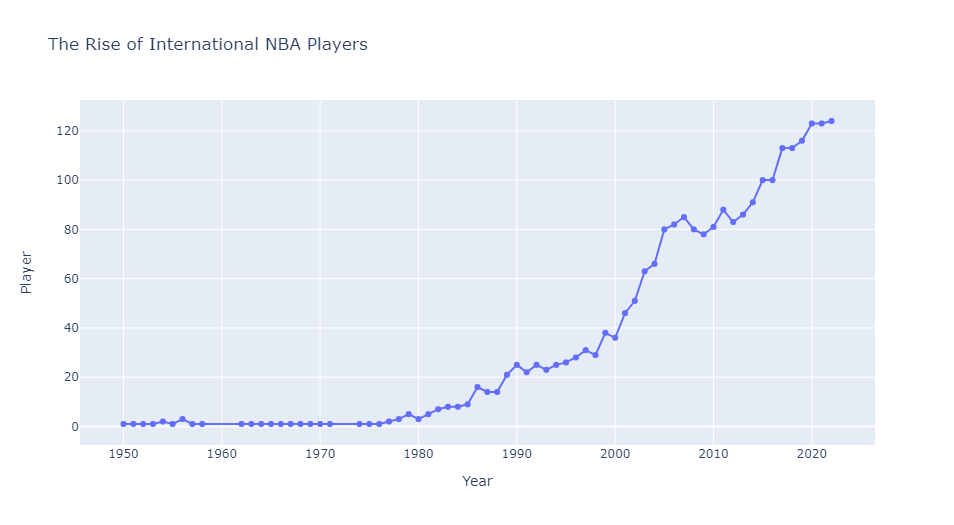

In [3]:
# Filtering the df to the 2000 season and later

player_df = player_stats[['Player','Pos','Year','G']]
player_df = player_df[player_df['Year']>=2000]
player_df.head()

,Player,Pos,Year,G
0,Bruno Fernando,C,2020,56
1,Bruno Fernando,C,2021,33
2,Bruno Fernando,C,2022,20
3,Bruno Fernando,C,2022,10
4,Leandro Bolmaro,SF,2022,35


In [4]:
# Grouping the df to sum the # of games played since 2000 and then filtering to greater than 50 games

player_df = pd.DataFrame(player_df.groupby(['Player','Pos'])['G'].sum().reset_index())
player_df = player_df[player_df['G']>50]

In [5]:
player_df.drop(['G'],axis=1, inplace=True)

In [6]:
# Creating a list of the players in the df, 
# This will help us to create the player id that helps us access Basketball Reference 

player_list = player_df['Player'].tolist()

The player id generally follows the format:

'last name initial' + '/' + 'first 5 initials of last name' + 'first 2 initials of first name' + '01'

In [7]:
ids = []
for player in player_list:
    a = str(player).replace('.','').replace("'", "")
    f='01'
    b=a.find(" ")
    c = len(a)
    if c-b>5:
        d=a[b+1:b+6]
    else:
        d=a[b+1:c]
    e=a[0:2]
    player_id = unidecode.unidecode(d[0].strip().lower()+'/'+d.strip().lower()+ e.strip().lower()+f.strip().lower())
    ids.append(player_id)

#### Fixing Incorrect Player IDs

There were some player ids that did not follow the general format, so I laid out the correct and incorrect ids below and map the correct ones to replace the incorrect ones.

In [8]:
player_df['player_id'] = ids

In [9]:
fixed_ids = ['o/osmande01','c/capelca01','a/anderda03', 'k/kanteen01','n/ntilila01','d/datomlu01','b/bareajo01','t/tayloje03',
 'g/greenjo02','n/navarju01','t/tilliki02','m/mbahalu01','k/klebima01','d/decolna01','h/hilarne01','p/pavloal01']

bad_ids = ['o/osmance01','c/capelcl01','a/anderda01','f/freeden01','n/ntilifr01','d/datomgi01','b/bareajj01',
't/tayloje01','g/greenjo01','c/carloju01','t/tilliki01','m/mbahlu01','k/klebema01','d/de cona01',
 'n/nenene01','p/pavlosa01']

In [10]:
player_df['player_id'] = player_df['player_id'].replace({'o/osmance01': 'o/osmande01', 'c/capelcl01': 'c/capelca01', 'a/anderda01': 'a/anderda03',
                           'f/freeden01': 'k/kanteen01', 'n/ntilifr01': 'n/ntilila01', 'd/datomgi01': 'd/datomlu01',
                           'b/bareajj01': 'b/bareajo01', 't/tayloje01': 't/tayloje03', 'g/greenjo01': 'g/greenjo02',
                           'c/carloju01': 'n/navarju01', 't/tilliki01': 't/tilliki02', 'm/mbahlu01': 'm/mbahalu01',
                           'k/klebema01': 'k/klebima01', 'd/de cona01': 'd/decolna01', 'n/nenene01': 'h/hilarne01',
                           'p/pavlosa01': 'p/pavloal01'})

In [11]:
player_df.loc[player_df['Player']=='Bojan Bogdanović','player_id'] = 'b/bogdabo02'

In [12]:
# Creating the player_ids list, which will be used to loop through each player's web page to scrape the stats
player_ids = player_df['player_id'].tolist()

### Scraping the Shooting Statistics

In [13]:
dfs = []
for player_id in player_ids:
    
    url = "https://www.basketball-reference.com/players/{}.html".format(player_id)
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    comments = soup.find_all(string=lambda text: isinstance(text, Comment))
    
    tables = []
    
    for each in comments:
        if 'table' in str(each):
            try:
                tables.append(pd.read_html(each, attrs = {'id': 'shooting'}, header=1)[0])
            except:
                continue
    try:
        df = tables[0]
        df = df[df['Season']=='Career']
        df['player_id'] = player_id
        dfs.append(df)
    except:
        pass

In [14]:
shooting_df = pd.concat(dfs)

In [15]:
# Adding the shootng statistics to our player df to create a combined df
combined_df = pd.merge(player_df, shooting_df, how = 'left', on = 'player_id')

In [16]:
combined_df.head()

,Player,Pos_x,player_id,Season,Age,Tm,Lg,Pos_y,G,MP,FG%,Dist.,Unnamed: 9,2P,0-3,3-10,10-16,16-3P,3P,Unnamed: 16,2P.1,0-3.1,3-10.1,10-16.1,16-3P.1,3P.1,Unnamed: 23,2P.2,3P.2,Unnamed: 26,%FGA,#,Unnamed: 29,%3PA,3P%,Unnamed: 32,Att.,#.1
0,Abdel Nader,SF,n/naderab01,Career,NaN,NaN,NBA,NaN,202.0,2583.0,0.428,13.3,NaN,0.550,0.299,0.192,0.035,0.024,0.450,NaN,0.486,0.614,0.349,0.296,0.263,0.357,NaN,0.572,0.976,NaN,0.035,24.0,NaN,0.357,0.392,NaN,2.0,0.0
1,Adonal Foyle,C,f/foylead01,Career,NaN,NaN,NBA,NaN,733.0,13060.0,0.477,4.9,NaN,0.999,0.424,0.453,0.094,0.028,0.001,NaN,0.477,0.583,0.414,0.349,0.321,0.000,NaN,0.605,NaN,NaN,0.077,192.0,NaN,0.000,NaN,NaN,0.0,0.0
2,Al Horford,C,h/horfoal01,Career,NaN,NaN,NBA,NaN,950.0,30597.0,0.515,11.3,NaN,0.839,0.276,0.223,0.126,0.214,0.161,NaN,0.544,0.729,0.449,0.443,0.465,0.360,NaN,0.696,0.970,NaN,0.079,788.0,NaN,0.192,0.354,NaN,2.0,0.0
3,Aleksej Pokusevski,PF,p/pokusal01,Career,NaN,NaN,NBA,NaN,106.0,2323.0,0.376,16.1,NaN,0.532,0.170,0.200,0.094,0.068,0.468,NaN,0.457,0.646,0.387,0.383,0.288,0.285,NaN,0.495,0.930,NaN,0.054,43.0,NaN,0.198,0.325,NaN,1.0,0.0
4,Alex Len,C,l/lenal01,Career,NaN,NaN,NBA,NaN,570.0,10769.0,0.507,6.5,NaN,0.899,0.517,0.213,0.089,0.080,0.101,NaN,0.527,0.656,0.384,0.315,0.311,0.329,NaN,0.688,0.991,NaN,0.212,625.0,NaN,0.473,0.367,NaN,3.0,0.0


In [17]:
# Dropping unwanted columns and renaming the columns that were duplicates after merging dfs

combined_df.drop(columns=['Pos_y','G','Season','Age','Tm','Lg','MP'],inplace=True)
combined_df.rename(columns={'Pos_x':'Pos'},inplace=True)
combined_df = combined_df[[x for x in combined_df if not x.startswith('Unnamed:')]]

In [18]:
combined_df.head()

,Player,Pos,player_id,FG%,Dist.,2P,0-3,3-10,10-16,16-3P,3P,2P.1,0-3.1,3-10.1,10-16.1,16-3P.1,3P.1,2P.2,3P.2,%FGA,#,%3PA,3P%,Att.,#.1
0,Abdel Nader,SF,n/naderab01,0.428,13.3,0.550,0.299,0.192,0.035,0.024,0.450,0.486,0.614,0.349,0.296,0.263,0.357,0.572,0.976,0.035,24.0,0.357,0.392,2.0,0.0
1,Adonal Foyle,C,f/foylead01,0.477,4.9,0.999,0.424,0.453,0.094,0.028,0.001,0.477,0.583,0.414,0.349,0.321,0.000,0.605,NaN,0.077,192.0,0.000,NaN,0.0,0.0
2,Al Horford,C,h/horfoal01,0.515,11.3,0.839,0.276,0.223,0.126,0.214,0.161,0.544,0.729,0.449,0.443,0.465,0.360,0.696,0.970,0.079,788.0,0.192,0.354,2.0,0.0
3,Aleksej Pokusevski,PF,p/pokusal01,0.376,16.1,0.532,0.170,0.200,0.094,0.068,0.468,0.457,0.646,0.387,0.383,0.288,0.285,0.495,0.930,0.054,43.0,0.198,0.325,1.0,0.0
4,Alex Len,C,l/lenal01,0.507,6.5,0.899,0.517,0.213,0.089,0.080,0.101,0.527,0.656,0.384,0.315,0.311,0.329,0.688,0.991,0.212,625.0,0.473,0.367,3.0,0.0


In [36]:
combined_df[combined_df['Player']=='Hakeem Olajuwon']

,Player,Pos,Player_ID,FG%,Avg_FGA_Dist,%FGA_2P,%FGA_0-3,%FGA_3-10,%FGA_10-16,%FGA_16-3P,%FGA_3P,2P_FG%,0-3_FG%,3-10_FG%,10-16_FG%,16-3P_FG%,3P_FG%,%AST_2P,%AST_3P,%FGA_Dunk,Dunks,%_Corner3PA,3P%_Corner3,Heave_Att,Heave_MD,FG_100,FGA_100,3P_100,3PA_100,2P_100,2PA_100,FT_100,FTA_100,FT%,ORB_100,DRB_100,TRB_100,AST_100,STL_100,BLK_100,TOV_100,PF_100,PTS_100,ORtg,DRtg,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
97,Hakeem Olajuwon,C,o/olajuha01,0.495,9.4,0.991,0.267,0.28,0.304,0.14,0.009,0.498,0.645,0.466,0.436,0.412,0.243,0.687,0.889,0.041,145.0,0.189,0.286,2.0,0.0,12.1,23.6,0.0,0.1,12.1,23.5,6.1,8.6,0.712,4.5,10.9,15.5,3.4,2.4,4.3,4.1,4.9,30.3,108.0,98.0,23.6,0.553,0.006,0.363,10.3,23.8,17.2,12.1,2.4,5.4,13.1,27.1,68.3,94.5,162.8,0.177,2.2,2.5,4.6,74.2


In [19]:
# Renaming all of the shooting columns

combined_df.columns = ['Player','Pos','Player_ID', 'FG%', 'Avg_FGA_Dist', '%FGA_2P', '%FGA_0-3',
                     '%FGA_3-10','%FGA_10-16', '%FGA_16-3P', '%FGA_3P', '2P_FG%',
                     '0-3_FG%', '3-10_FG%', '10-16_FG%', '16-3P_FG%', '3P_FG%', '%AST_2P', '%AST_3P',
                     '%FGA_Dunk', 'Dunks', '%_Corner3PA', '3P%_Corner3',
                     'Heave_Att', 'Heave_MD']

In [20]:
combined_df.head()

,Player,Pos,Player_ID,FG%,Avg_FGA_Dist,%FGA_2P,%FGA_0-3,%FGA_3-10,%FGA_10-16,%FGA_16-3P,%FGA_3P,2P_FG%,0-3_FG%,3-10_FG%,10-16_FG%,16-3P_FG%,3P_FG%,%AST_2P,%AST_3P,%FGA_Dunk,Dunks,%_Corner3PA,3P%_Corner3,Heave_Att,Heave_MD
0,Abdel Nader,SF,n/naderab01,0.428,13.3,0.550,0.299,0.192,0.035,0.024,0.450,0.486,0.614,0.349,0.296,0.263,0.357,0.572,0.976,0.035,24.0,0.357,0.392,2.0,0.0
1,Adonal Foyle,C,f/foylead01,0.477,4.9,0.999,0.424,0.453,0.094,0.028,0.001,0.477,0.583,0.414,0.349,0.321,0.000,0.605,NaN,0.077,192.0,0.000,NaN,0.0,0.0
2,Al Horford,C,h/horfoal01,0.515,11.3,0.839,0.276,0.223,0.126,0.214,0.161,0.544,0.729,0.449,0.443,0.465,0.360,0.696,0.970,0.079,788.0,0.192,0.354,2.0,0.0
3,Aleksej Pokusevski,PF,p/pokusal01,0.376,16.1,0.532,0.170,0.200,0.094,0.068,0.468,0.457,0.646,0.387,0.383,0.288,0.285,0.495,0.930,0.054,43.0,0.198,0.325,1.0,0.0
4,Alex Len,C,l/lenal01,0.507,6.5,0.899,0.517,0.213,0.089,0.080,0.101,0.527,0.656,0.384,0.315,0.311,0.329,0.688,0.991,0.212,625.0,0.473,0.367,3.0,0.0


### Scraping the Per 100 Possession Stats

In [21]:
dfs = []
for player_id in player_ids:
    
    url = "https://www.basketball-reference.com/players/{}.html".format(player_id)
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    comments = soup.find_all(string=lambda text: isinstance(text, Comment))
    
    tables = []
    
    for each in comments:
        if 'table' in str(each):
            try:
                tables.append(pd.read_html(each, attrs = {'id': 'per_poss'}, header=0)[0])
            except:
                continue
    try:
        df = tables[0]
        df = df[df['Season']=='Career']
        df['player_id'] = player_id
        dfs.append(df)
    except:
        pass

In [22]:
per_poss_df = pd.concat(dfs)

In [23]:
per_poss_df.head()

,Season,Age,Tm,Lg,Pos,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Unnamed: 29,ORtg,DRtg,player_id
5,Career,NaN,NaN,NBA,NaN,202.0,8.0,2583.0,6.2,14.6,0.428,2.3,6.6,0.357,3.9,8.0,0.486,2.5,3.5,0.718,1.0,6.1,7.0,2.1,1.4,1.0,2.5,4.6,17.4,NaN,100.0,109.0,n/naderab01
14,Career,NaN,NaN,NBA,NaN,733.0,269.0,13060.0,5.2,10.9,0.477,0.0,0.0,0.000,5.2,10.8,0.477,1.4,2.8,0.499,5.1,8.5,13.6,1.3,1.0,4.7,2.3,6.2,11.7,NaN,99.0,104.0,f/foylead01
15,Career,NaN,NaN,NBA,NaN,950.0,940.0,30597.0,9.0,17.6,0.515,1.0,2.8,0.360,8.0,14.7,0.544,2.5,3.4,0.759,3.2,9.7,12.9,5.2,1.3,1.9,2.4,3.5,21.6,NaN,115.0,105.0,h/horfoal01
2,Career,NaN,NaN,NBA,NaN,106.0,40.0,2323.0,6.7,17.9,0.376,2.4,8.4,0.285,4.4,9.5,0.457,1.4,1.9,0.717,2.1,8.9,11.0,4.7,1.2,1.7,4.0,3.0,17.2,NaN,89.0,112.0,p/pokusal01
13,Career,NaN,NaN,NBA,NaN,570.0,235.0,10769.0,7.5,14.8,0.507,0.5,1.5,0.329,7.0,13.3,0.527,4.0,5.8,0.683,4.8,10.1,14.9,2.2,1.0,2.4,3.0,6.5,19.4,NaN,109.0,109.0,l/lenal01


In [24]:
# Dropping unwanted columns

per_poss_df.drop(columns=['Pos','G','GS','MP','Season','Age','Tm','Lg','FG%','3P%','2P%'],inplace=True)
per_poss_df = per_poss_df[[x for x in per_poss_df if not x.startswith('Unnamed:')]]

In [25]:
# Renaming all of the per 100 possession columns

per_poss_df.columns = ["FG_100","FGA_100","3P_100","3PA_100","2P_100","2PA_100",
                        "FT_100","FTA_100","FT%","ORB_100","DRB_100","TRB_100","AST_100","STL_100","BLK_100",
                        "TOV_100","PF_100","PTS_100","ORtg","DRtg", 'Player_ID']

In [26]:
# Adding the per 100 possession stats to the combined df

combined_df = pd.merge(combined_df,per_poss_df,how='left',on='Player_ID')

### Scraping the Advanced Stats

In [27]:
dfs = []
for player_id in player_ids:
    url = 'https://www.basketball-reference.com/players/{}.html'.format(player_id)
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    advanced_table = soup.find_all(id="all_advanced-playoffs_advanced")
    df = pd.read_html(str(advanced_table))[0]
    df= df[df['Season']=='Career']
    df['Player_ID'] = player_id
    dfs.append(df)

In [28]:
advanced_df = pd.concat(dfs)

In [29]:
advanced_df.head()

,Season,Age,Tm,Lg,Pos,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,Unnamed: 19,OWS,DWS,WS,WS/48,Unnamed: 24,OBPM,DBPM,BPM,VORP,Player_ID
5,Career,NaN,NaN,NBA,NaN,202.0,2583.0,9.3,0.538,0.450,0.242,2.2,13.5,7.9,6.0,1.4,1.8,13.4,16.7,NaN,-0.5,3.2,2.8,0.052,NaN,-3.0,0.4,-2.6,-0.4,n/naderab01
14,Career,NaN,NaN,NBA,NaN,733.0,13060.0,12.3,0.486,0.001,0.256,10.5,18.4,14.3,4.0,1.0,6.4,16.2,12.2,NaN,3.2,15.4,18.7,0.069,NaN,-2.8,1.2,-1.7,1.1,f/foylead01
15,Career,NaN,NaN,NBA,NaN,950.0,30597.0,18.5,0.568,0.161,0.191,7.3,21.4,14.4,16.6,1.3,3.0,11.2,19.0,NaN,55.5,44.8,100.3,0.157,NaN,1.7,1.2,2.9,37.9,h/horfoal01
2,Career,NaN,NaN,NBA,NaN,106.0,2323.0,9.2,0.459,0.468,0.106,4.5,19.3,11.8,14.9,1.2,3.1,17.6,20.2,NaN,-4.0,2.4,-1.5,-0.032,NaN,-3.8,-0.4,-4.2,-1.3,p/pokusal01
13,Career,NaN,NaN,NBA,NaN,570.0,10769.0,15.2,0.561,0.101,0.396,10.6,23.1,16.8,6.9,1.0,4.2,14.8,17.9,NaN,10.5,11.1,21.6,0.096,NaN,-1.8,-0.1,-1.9,0.2,l/lenal01


In [30]:
# Dropping unwanted columns

advanced_df.drop(columns=['Pos','G','MP','Season','Age','Tm','Lg'],inplace=True)
advanced_df = advanced_df[[x for x in advanced_df if not x.startswith('Unnamed:')]]

In [31]:
# Adding the advanced stats to the combined df

combined_df = pd.merge(combined_df,advanced_df,how='left',on='Player_ID')

In [32]:
combined_df.head()

,Player,Pos,Player_ID,FG%,Avg_FGA_Dist,%FGA_2P,%FGA_0-3,%FGA_3-10,%FGA_10-16,%FGA_16-3P,%FGA_3P,2P_FG%,0-3_FG%,3-10_FG%,10-16_FG%,16-3P_FG%,3P_FG%,%AST_2P,%AST_3P,%FGA_Dunk,Dunks,%_Corner3PA,3P%_Corner3,Heave_Att,Heave_MD,FG_100,FGA_100,3P_100,3PA_100,2P_100,2PA_100,FT_100,FTA_100,FT%,ORB_100,DRB_100,TRB_100,AST_100,STL_100,BLK_100,TOV_100,PF_100,PTS_100,ORtg,DRtg,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,Abdel Nader,SF,n/naderab01,0.428,13.3,0.550,0.299,0.192,0.035,0.024,0.450,0.486,0.614,0.349,0.296,0.263,0.357,0.572,0.976,0.035,24.0,0.357,0.392,2.0,0.0,6.2,14.6,2.3,6.6,3.9,8.0,2.5,3.5,0.718,1.0,6.1,7.0,2.1,1.4,1.0,2.5,4.6,17.4,100.0,109.0,9.3,0.538,0.450,0.242,2.2,13.5,7.9,6.0,1.4,1.8,13.4,16.7,-0.5,3.2,2.8,0.052,-3.0,0.4,-2.6,-0.4
1,Adonal Foyle,C,f/foylead01,0.477,4.9,0.999,0.424,0.453,0.094,0.028,0.001,0.477,0.583,0.414,0.349,0.321,0.000,0.605,NaN,0.077,192.0,0.000,NaN,0.0,0.0,5.2,10.9,0.0,0.0,5.2,10.8,1.4,2.8,0.499,5.1,8.5,13.6,1.3,1.0,4.7,2.3,6.2,11.7,99.0,104.0,12.3,0.486,0.001,0.256,10.5,18.4,14.3,4.0,1.0,6.4,16.2,12.2,3.2,15.4,18.7,0.069,-2.8,1.2,-1.7,1.1
2,Al Horford,C,h/horfoal01,0.515,11.3,0.839,0.276,0.223,0.126,0.214,0.161,0.544,0.729,0.449,0.443,0.465,0.360,0.696,0.970,0.079,788.0,0.192,0.354,2.0,0.0,9.0,17.6,1.0,2.8,8.0,14.7,2.5,3.4,0.759,3.2,9.7,12.9,5.2,1.3,1.9,2.4,3.5,21.6,115.0,105.0,18.5,0.568,0.161,0.191,7.3,21.4,14.4,16.6,1.3,3.0,11.2,19.0,55.5,44.8,100.3,0.157,1.7,1.2,2.9,37.9
3,Aleksej Pokusevski,PF,p/pokusal01,0.376,16.1,0.532,0.170,0.200,0.094,0.068,0.468,0.457,0.646,0.387,0.383,0.288,0.285,0.495,0.930,0.054,43.0,0.198,0.325,1.0,0.0,6.7,17.9,2.4,8.4,4.4,9.5,1.4,1.9,0.717,2.1,8.9,11.0,4.7,1.2,1.7,4.0,3.0,17.2,89.0,112.0,9.2,0.459,0.468,0.106,4.5,19.3,11.8,14.9,1.2,3.1,17.6,20.2,-4.0,2.4,-1.5,-0.032,-3.8,-0.4,-4.2,-1.3
4,Alex Len,C,l/lenal01,0.507,6.5,0.899,0.517,0.213,0.089,0.080,0.101,0.527,0.656,0.384,0.315,0.311,0.329,0.688,0.991,0.212,625.0,0.473,0.367,3.0,0.0,7.5,14.8,0.5,1.5,7.0,13.3,4.0,5.8,0.683,4.8,10.1,14.9,2.2,1.0,2.4,3.0,6.5,19.4,109.0,109.0,15.2,0.561,0.101,0.396,10.6,23.1,16.8,6.9,1.0,4.2,14.8,17.9,10.5,11.1,21.6,0.096,-1.8,-0.1,-1.9,0.2


In [33]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 292 entries, 0 to 291
Data columns (total 65 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Player        292 non-null    object 
 1   Pos           292 non-null    object 
 2   Player_ID     292 non-null    object 
 3   FG%           292 non-null    float64
 4   Avg_FGA_Dist  292 non-null    float64
 5   %FGA_2P       292 non-null    float64
 6   %FGA_0-3      292 non-null    float64
 7   %FGA_3-10     292 non-null    float64
 8   %FGA_10-16    292 non-null    float64
 9   %FGA_16-3P    292 non-null    float64
 10  %FGA_3P       292 non-null    float64
 11  2P_FG%        292 non-null    float64
 12  0-3_FG%       292 non-null    float64
 13  3-10_FG%      292 non-null    float64
 14  10-16_FG%     292 non-null    float64
 15  16-3P_FG%     289 non-null    float64
 16  3P_FG%        277 non-null    float64
 17  %AST_2P       292 non-null    float64
 18  %AST_3P       245 non-null    

In [34]:
# Convert nulls to 0
combined_df = combined_df.fillna(0)

In [35]:
combined_df.to_csv(r'Documents\International Player Career Average Stats.csv', index=False)